# **Drive Mounting directly on Google colab**

In [ ]:
from google.colab import drive
import zipfile, os

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = "/content/drive/MyDrive"

In [ ]:
print("Files in MyDrive:", os.listdir(DATA_DIR))

Files in MyDrive: ['Colab Notebooks', 'Tech M Project Progress', 'Tamanna_Resumes', 'Imagica Pics', 'Japan_Tech_M', 'MUFG SIH', 'Dataset files_MUFG_SIH.gdoc']


In [ ]:
DATA_DIR = "/content/drive/MyDrive/MUFG SIH"

In [ ]:
print("Files in MUFG SIH:", os.listdir(DATA_DIR))

Files in MUFG SIH: ['email_phishing_dataset.zip', 'Dataset files_MUFG_SIH.gdoc', 'AgenticAI_approach.svg', 'Deepfake_video.zip', 'MUFG', 'SIH2025_Presentation.pptx.pdf', 'Deepfake_audio.zip', 'phishnet']


In [ ]:
text_out  = "/content/email_phishing_dataset"
audio_out = "/content/deepfake_audio_dataset"
video_out = "/content/deepfake_video_dataset"

In [ ]:
os.makedirs(text_out, exist_ok=True)
os.makedirs(audio_out, exist_ok=True)
os.makedirs(video_out, exist_ok=True)

In [ ]:
with zipfile.ZipFile(f"{DATA_DIR}/email_phishing_dataset.zip", 'r') as z:
    z.extractall(text_out)

In [ ]:
with zipfile.ZipFile(f"{DATA_DIR}/Deepfake_audio.zip", 'r') as z:
    z.extractall(audio_out)

In [ ]:
with zipfile.ZipFile(f"{DATA_DIR}/Deepfake_video.zip", 'r') as z:
    z.extractall(video_out)

In [ ]:
print("✅ Extraction complete")
print("Text files:", len(os.listdir(text_out)))
print("Audio files:", len(os.listdir(audio_out)))
print("Video files:", len(os.listdir(video_out)))

✅ Extraction complete
Text files: 7
Audio files: 4
Video files: 2


# **Text Preprocessing**

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")   # 👈 NEW
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re, nltk, unicodedata, os
from nltk.corpus import stopwords

# download all necessary nltk data
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))

def preprocess_email(text):
    text = unicodedata.normalize("NFKC", text.lower())
    text = re.sub(r"https?://\S+", "URL", text)   # mask URLs
    text = re.sub(r"[^a-z\s]", " ", text)         # remove non-letters
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w not in STOPWORDS]
    return " ".join(tokens)

text_dir = "/content/email_phishing_dataset"
processed_texts = {}

for fname in os.listdir(text_dir):
    fpath = os.path.join(text_dir, fname)
    with open(fpath, "r", errors="ignore") as f:
        raw = f.read()
        processed_texts[fname] = preprocess_email(raw)

print("✅ Processed text samples:")
for k,v in list(processed_texts.items())[:2]:
    print(f"{k}: {v[:150]}...")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Processed text samples:
Nigerian_Fraud.csv: sender receiver date subject body urls label mr james ngola james ngola maktoob com webmaster aclweb org thu oct urgent business assistance partnershi...
Enron.csv: subject body label hpl nom may see attached file hplno xls hplno xls nom actual vols th forwarded sabrae zajac hou ect pm enron capital trade resource...


# **Audio Processing**

In [ ]:
import os
print(os.listdir("/content/deepfake_audio_dataset"))


['for-original', 'for-norm', 'for-rerec', 'for-2sec']


In [ ]:
import os, glob, librosa, numpy as np, pandas as pd
from tqdm import tqdm

audio_root = "/content/deepfake_audio_dataset"

# grab common audio types recursively
exts = ["wav","mp3","flac","m4a","ogg","aac","wma"]
audio_files = []
for ext in exts:
    audio_files += glob.glob(f"{audio_root}/**/*.{ext}", recursive=True)

print(f"Found {len(audio_files)} audio files")
if len(audio_files) < 1:
    # quick debug: show tree
    for root, dirs, files in os.walk(audio_root):
        print(root, files[:5])

def subset_from_path(path: str) -> str:
    # returns the immediate subfolder under audio_root, e.g., 'for-original'
    rel = os.path.relpath(path, audio_root)
    parts = rel.split(os.sep)
    return parts[0] if len(parts) > 1 else "root"

def mfcc_mean_vec(path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(path, sr=sr, mono=True)
    # skip super short/empty clips
    if len(y) < sr:   # < 1 second
        return None
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, T)
    return mfcc.mean(axis=1)  # (n_mfcc,)

rows = []
skipped = 0
for fpath in tqdm(audio_files):
    try:
        vec = mfcc_mean_vec(fpath)
        if vec is None:
            skipped += 1
            continue
        rows.append({
            "file": os.path.basename(fpath),
            "rel_path": os.path.relpath(fpath, audio_root),
            "subset": subset_from_path(fpath),
            **{f"mfcc_{i+1}": v for i, v in enumerate(vec)}
        })
    except Exception as e:
        skipped += 1
        print(f"⚠️ skip {fpath}: {e}")

df_audio = pd.DataFrame(rows)
save_csv = "/content/drive/MyDrive/processed/processed_audio_mfcc.csv"
os.makedirs(os.path.dirname(save_csv), exist_ok=True)
df_audio.to_csv(save_csv, index=False)

print(f"✅ Saved {len(df_audio)} rows to: {save_csv} | skipped: {skipped}")
print("Counts by subset:\n", df_audio["subset"].value_counts(dropna=False))
df_audio.head()


Found 169754 audio files


 84%|████████▍ | 142532/169754 [38:11<05:22, 84.32it/s]/tmp/ipython-input-2868322402.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 142551/169754 [38:11<05:16, 86.00it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file32972.mp3: 


 86%|████████▋ | 146770/169754 [39:13<14:25, 26.55it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file31017.mp3: 


 87%|████████▋ | 147565/169754 [39:27<03:56, 94.01it/s]/tmp/ipython-input-2868322402.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 147586/169754 [39:27<03:52, 95.49it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file17407.mp3: 


 87%|████████▋ | 147960/169754 [39:32<05:06, 71.08it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file16643.mp3: 


 89%|████████▉ | 150876/169754 [40:13<03:09, 99.58it/s]/tmp/ipython-input-2868322402.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 150886/169754 [40:13<03:20, 94.18it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file15746.mp3: 


 91%|█████████▏| 155157/169754 [41:10<02:27, 98.97it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file27839.mp3: 


 93%|█████████▎| 157125/169754 [41:36<02:06, 100.06it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file27206.mp3: 


 93%|█████████▎| 157903/169754 [41:44<01:56, 101.83it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file30959.mp3: 


 93%|█████████▎| 158186/169754 [41:50<01:55, 99.84it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file5323.mp3: 


 94%|█████████▎| 159090/169754 [41:59<02:55, 60.75it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file19851.mp3: 


 94%|█████████▍| 159555/169754 [42:07<01:37, 104.56it/s]/tmp/ipython-input-2868322402.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 159579/169754 [42:07<01:35, 107.08it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file27643.mp3: 


 95%|█████████▌| 161926/169754 [42:40<01:12, 108.04it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file9875.mp3: 


 95%|█████████▌| 162023/169754 [42:41<01:15, 101.96it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file13424.mp3: 


 96%|█████████▌| 162454/169754 [42:49<01:10, 104.14it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/training/fake/file17450.mp3: 


 99%|█████████▊| 167592/169754 [43:55<00:21, 99.33it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/validation/fake/file16165.mp3: 


100%|█████████▉| 168942/169754 [44:16<00:09, 89.31it/s]

⚠️ skip /content/deepfake_audio_dataset/for-original/for-original/validation/fake/file31606.mp3: 


100%|██████████| 169754/169754 [44:24<00:00, 63.72it/s]


✅ Saved 163934 rows to: /content/drive/MyDrive/processed/processed_audio_mfcc.csv | skipped: 5820
Counts by subset:
 subset
for-original    68725
for-norm        64071
for-2sec        17870
for-rerec       13268
Name: count, dtype: int64


,file,rel_path,subset,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,file2107.wav,for-original/for-original/testing/real/file210...,for-original,-256.349731,118.939629,10.461822,39.780823,-19.730724,1.610053,0.178933,-19.666792,-3.273839,-5.444699,-14.346134,3.951661,-11.747244
1,file447.wav,for-original/for-original/testing/real/file447...,for-original,-261.060730,56.958260,0.395447,27.690630,-16.021925,2.031633,-11.167014,3.969359,-6.651355,7.207430,-15.071536,2.343977,-3.343426
2,file125.wav,for-original/for-original/testing/real/file125...,for-original,-251.605392,75.884338,11.717957,38.722553,-14.731581,1.523854,-5.391181,2.426846,-8.268317,2.001301,-19.832516,1.563768,-5.711736
3,file1784.wav,for-original/for-original/testing/real/file178...,for-original,-207.510803,95.789398,11.629858,50.834805,-19.259535,4.548469,-9.069361,-21.645176,-7.678545,-6.596760,-10.368109,6.243602,-9.397346
4,file1360.wav,for-original/for-original/testing/real/file136...,for-original,-217.653091,94.334496,1.279012,18.014864,-23.635376,10.071319,-20.874025,-1.791503,-6.930730,4.236859,-13.713974,4.124651,-10.458508


# **Video Processing**

In [10]:
import os, shutil
from google.colab import drive

# If the folder exists but isn't an active mount, remove it
if os.path.exists('/content/drive') and not os.path.ismount('/content/drive'):
    shutil.rmtree('/content/drive')

os.makedirs('/content/drive', exist_ok=True)
drive.mount('/content/drive', force_remount=True)  # follow the auth link and pick the account with MUFG SIH


Mounted at /content/drive


In [11]:
import os

# Peek what's actually in your My Drive
print("MyDrive:", os.listdir("/content/drive/MyDrive"))

# Set your MUFG/SIH path (note the SPACE in the folder name)
DATA_DIR = "/content/drive/MyDrive/MUFG SIH"
print("Exists?", os.path.exists(DATA_DIR))
if os.path.exists(DATA_DIR):
    print("MUFG SIH contents:", os.listdir(DATA_DIR))


MyDrive: ['Tech M Project Progress', 'Tamanna_Resumes', 'Imagica Pics', 'Japan_Tech_M', 'MUFG SIH', 'Dataset files_MUFG_SIH.gdoc', 'Colab Notebooks', 'processed']
Exists? True
MUFG SIH contents: ['email_phishing_dataset.zip', 'Dataset files_MUFG_SIH.gdoc', 'AgenticAI_approach.svg', 'Deepfake_video.zip', 'MUFG', 'SIH2025_Presentation.pptx.pdf', 'Deepfake_audio.zip', 'phishnet']


In [4]:
# ==== VIDEO: extract -> find -> frame-sample -> manifest (simple & stable) ====
!pip install -q opencv-python-headless pandas tqdm

import os, zipfile, shutil, cv2, pandas as pd
from tqdm import tqdm

# ---- paths (confirmed from your Step 1) ----
DATA_DIR   = "/content/drive/MyDrive/MUFG SIH"
VIDEO_ZIP  = os.path.join(DATA_DIR, "Deepfake_video.zip")
VIDEO_ROOT = "/content/deepfake_video_dataset"   # extraction target
FRAMES_ROOT  = "/content/processed_video_frames"
MANIFEST_CSV = "/content/drive/MyDrive/processed/video_frames_manifest.csv"

# ---- clean extract ----
assert os.path.exists(VIDEO_ZIP), f"Zip not found at {VIDEO_ZIP}"
if os.path.exists(VIDEO_ROOT):
    shutil.rmtree(VIDEO_ROOT)
os.makedirs(VIDEO_ROOT, exist_ok=True)
with zipfile.ZipFile(VIDEO_ZIP, "r") as z:
    z.extractall(VIDEO_ROOT)
print("✅ Extracted:", VIDEO_ZIP)
print("Top-level after extract:", os.listdir(VIDEO_ROOT)[:15])

# ---- helpers ----
def list_videos(root):
    exts = (".mp4",".mkv",".mov",".avi",".webm",".m4v",".MP4",".MKV",".MOV",".AVI",".WEBM",".M4V")
    vids=[]
    for dp,_,files in os.walk(root):
        for f in files:
            if f.endswith(exts):
                vids.append(os.path.join(dp,f))
    return vids

# ---- handle nested folder or nested zips if any ----
videos = list_videos(VIDEO_ROOT)
if len(videos) == 0:
    # single nested folder case
    entries = [os.path.join(VIDEO_ROOT, e) for e in os.listdir(VIDEO_ROOT)]
    subdirs = [e for e in entries if os.path.isdir(e)]
    if len(subdirs) == 1:
        VIDEO_ROOT = subdirs[0]
        print("ℹ️ Using nested folder:", VIDEO_ROOT)
        videos = list_videos(VIDEO_ROOT)

if len(videos) == 0:
    # nested zips case
    nested_zips = []
    for dp,_,files in os.walk(VIDEO_ROOT):
        for f in files:
            if f.lower().endswith(".zip"):
                nested_zips.append(os.path.join(dp,f))
    if nested_zips:
        print("ℹ️ Found nested zips; extracting them...")
        for nz in nested_zips:
            try:
                with zipfile.ZipFile(nz, "r") as z:
                    z.extractall(os.path.dirname(nz))
            except Exception as e:
                print("   ⚠️ Could not extract", nz, ":", e)
        videos = list_videos(VIDEO_ROOT)

print(f"🎞 Found {len(videos)} video files under: {VIDEO_ROOT}")
print("Sample:", [v.replace(VIDEO_ROOT + '/', '') for v in videos[:5]])

# ---- stop early if no videos ----
if len(videos) == 0:
    raise SystemExit("❌ No videos found after extraction. Check zip contents or share one filename shown in the folder.")

# ---- frame extraction config ----
FPS_OUT, SIZE, QUALITY = 5, 224, 95
def sample_step(src_fps, fps_out):
    if not src_fps or src_fps <= 0: src_fps = 30.0
    return max(1, int(round(src_fps / fps_out)))
def safe_name(root, path):
    rel = os.path.relpath(path, root)
    base = os.path.splitext(rel)[0]
    return base.replace(os.sep, "__").replace(" ", "_")

os.makedirs(FRAMES_ROOT, exist_ok=True)
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)

# ---- process videos -> frames + manifest ----
rows=[]
for vp in tqdm(sorted(videos), desc="extracting frames"):
    cap = cv2.VideoCapture(vp)
    if not cap.isOpened():
        print("⚠️ could not open:", vp);
        continue
    src_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = sample_step(src_fps, FPS_OUT)
    out_dir = os.path.join(FRAMES_ROOT, safe_name(VIDEO_ROOT, vp))
    os.makedirs(out_dir, exist_ok=True)

    idx=saved=0
    while True:
        ok, frame = cap.read()
        if not ok: break
        if idx % step == 0:
            frame = cv2.resize(frame, (SIZE, SIZE))
            cv2.imwrite(os.path.join(out_dir, f"frame_{saved:05d}.jpg"),
                        frame, [int(cv2.IMWRITE_JPEG_QUALITY), QUALITY])
            saved += 1
        idx += 1
    cap.release()

    rows.append({
        "video_rel_path": os.path.relpath(vp, VIDEO_ROOT),
        "frames_dir": out_dir,
        "num_frames": saved,
        "fps_out": FPS_OUT,
        "size": SIZE,
        "src_fps": float(src_fps),
    })

df = pd.DataFrame(rows)
df.to_csv(MANIFEST_CSV, index=False)
print(f"✅ Processed {len(df)} videos | Manifest: {MANIFEST_CSV}")
print(df.head(3))


✅ Extracted: /content/drive/MyDrive/MUFG SIH/Deepfake_video.zip
Top-level after extract: ['DFD_original sequences', 'DFD_manipulated_sequences']
🎞 Found 3431 video files under: /content/deepfake_video_dataset
Sample: ['DFD_original sequences/06__podium_speech_happy.mp4', 'DFD_original sequences/01__kitchen_pan.mp4', 'DFD_original sequences/10__talking_against_wall.mp4', 'DFD_original sequences/11__outside_talking_still_laughing.mp4', 'DFD_original sequences/13__talking_against_wall.mp4']


extracting frames: 100%|██████████| 3431/3431 [7:57:14<00:00,  8.35s/it]


✅ Processed 3431 videos | Manifest: /content/drive/MyDrive/processed/video_frames_manifest.csv
                                      video_rel_path  \
0  DFD_manipulated_sequences/DFD_manipulated_sequ...   
1  DFD_manipulated_sequences/DFD_manipulated_sequ...   
2  DFD_manipulated_sequences/DFD_manipulated_sequ...   

                                          frames_dir  num_frames  fps_out  \
0  /content/processed_video_frames/DFD_manipulate...          42        5   
1  /content/processed_video_frames/DFD_manipulate...         116        5   
2  /content/processed_video_frames/DFD_manipulate...         209        5   

   size  src_fps  
0   224     24.0  
1   224     24.0  
2   224     24.0  


# **Classification whether the data is audio , video or text from a common box of mixed items **

In [5]:
# ==== UNIDENTIFIED BOX → classify files by modality (text/audio/video/image/doc/unknown) ====
# NO routing, NO models — just file classification (+ .eml attachments)

# System + Python deps (safe for Colab)
!apt-get -y -qq install libmagic1 >/dev/null
!pip -q install python-magic pandas tqdm

import os, mimetypes, hashlib, magic, pandas as pd
from tqdm import tqdm
from email import policy
from email.parser import BytesParser

# --------- CONFIG ---------
# Your generic “box” (put any files in here); also include your processed folders for convenience.
BOX_DIR   = "/content/box"  # change if you want
TEXT_DIR  = "/content/email_phishing_dataset"
AUDIO_DIR = "/content/deepfake_audio_dataset"
VIDEO_DIR = "/content/deepfake_video_dataset"

SEARCH_ROOTS = [p for p in [BOX_DIR, TEXT_DIR, AUDIO_DIR, VIDEO_DIR] if os.path.exists(p)]
OUT_CSV = "/content/drive/MyDrive/processed/classify_manifest.csv"

# --------- MIME → modality helpers ---------
MAGIC = magic.Magic(mime=True)

EXT_MAP = {
    # text
    ".txt":"text",".csv":"text",".json":"text",".md":"text",".html":"text",".htm":"text",".eml":"text",
    # audio
    ".wav":"audio",".mp3":"audio",".flac":"audio",".m4a":"audio",".ogg":"audio",".aac":"audio",".wma":"audio",
    # video
    ".mp4":"video",".mov":"video",".mkv":"video",".avi":"video",".webm":"video",".m4v":"video",
    # image
    ".png":"image",".jpg":"image",".jpeg":"image",".bmp":"image",".gif":"image",".webp":"image",".tiff":"image",
    # docs
    ".pdf":"doc",".doc":"doc",".docx":"doc",".ppt":"doc",".pptx":"doc",".xls":"doc",".xlsx":"doc"
}

def modality_from_mime(mime: str) -> str:
    if not mime: return "unknown"
    major = mime.split("/")[0]
    if major in ("audio","video","image","text"):
        return major
    if mime == "application/pdf": return "doc"
    if mime.startswith("application/vnd") or mime.startswith("application/ms"):
        return "doc"
    return "unknown"

def sha256_file(path, chunk=65536, cap=100*1024*1024):
    try:
        size = os.path.getsize(path)
        if size is None or size > cap:
            return None
        h = hashlib.sha256()
        with open(path, "rb") as f:
            while True:
                b = f.read(chunk)
                if not b: break
                h.update(b)
        return h.hexdigest()
    except Exception:
        return None

def classify_file(path: str):
    ext = os.path.splitext(path)[1].lower()
    size = None
    try: size = os.path.getsize(path)
    except Exception: pass

    # MIME sniff with libmagic → fallback to mimetypes
    try:
        mime = MAGIC.from_file(path)
    except Exception:
        mime = mimetypes.guess_type(path)[0]

    modality = modality_from_mime(mime)
    if modality == "unknown":
        modality = EXT_MAP.get(ext, "unknown")

    return {
        "path": path,
        "filename": os.path.basename(path),
        "ext": ext,
        "mime": mime,
        "modality": modality,
        "size_bytes": size,
        "sha256": sha256_file(path),
        "is_attachment": False,
        "parent": None,
    }

def attachments_from_eml(eml_path: str):
    """Parse .eml and classify attachments as separate rows (virtual paths)."""
    rows = []
    try:
        with open(eml_path, "rb") as f:
            msg = BytesParser(policy=policy.default).parse(f)
        for part in msg.walk():
            if part.is_attachment():
                fname = part.get_filename() or "attachment"
                ctype = part.get_content_type()
                payload = part.get_payload(decode=True) or b""
                mod = modality_from_mime(ctype)
                rows.append({
                    "path": eml_path + f"::attachment::{fname}",
                    "filename": fname,
                    "ext": os.path.splitext(fname)[1].lower(),
                    "mime": ctype,
                    "modality": mod,
                    "size_bytes": len(payload),
                    "sha256": hashlib.sha256(payload).hexdigest() if payload else None,
                    "is_attachment": True,
                    "parent": eml_path,
                })
    except Exception:
        pass
    return rows

# --------- Walk roots & classify ---------
rows = []
for root in SEARCH_ROOTS:
    for dp, _, files in os.walk(root):
        for fn in files:
            full = os.path.join(dp, fn)
            info = classify_file(full)
            rows.append(info)
            if info["ext"] == ".eml":
                rows += attachments_from_eml(full)

df = pd.DataFrame(rows)

# Save + print summary
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df.to_csv(OUT_CSV, index=False)
print(f"✅ Classification manifest written: {OUT_CSV}")
print(f"Rows: {len(df)}")

if not df.empty:
    print("\nCounts by modality:")
    print(df["modality"].value_counts(dropna=False))
    print("\nSample:")
    print(df[["filename","modality","ext","mime","size_bytes","is_attachment"]].head(12).to_string(index=False))


✅ Classification manifest written: /content/drive/MyDrive/processed/classify_manifest.csv
Rows: 3432

Counts by modality:
modality
video      3431
unknown       1
Name: count, dtype: int64

Sample:
                              filename modality  ext      mime  size_bytes  is_attachment
           06__podium_speech_happy.mp4    video .mp4 video/mp4     8949516          False
                   01__kitchen_pan.mp4    video .mp4 video/mp4     4330494          False
          10__talking_against_wall.mp4    video .mp4 video/mp4     5188235          False
11__outside_talking_still_laughing.mp4    video .mp4 video/mp4     7705656          False
          13__talking_against_wall.mp4    video .mp4 video/mp4     5278061          False
 20__walking_and_outside_surprised.mp4    video .mp4 video/mp4    20371057          False
  18__outside_talking_pan_laughing.mp4    video .mp4 video/mp4    11364089          False
               16__exit_phone_room.mp4    video .mp4 video/mp4     3113649        

In [18]:
import zipfile, os, collections

DATA_DIR  = "/content/drive/MyDrive/MUFG SIH"
zips = {
  "text":  f"{DATA_DIR}/email_phishing_dataset.zip",
  "audio": f"{DATA_DIR}/Deepfake_audio.zip",
  "video": f"{DATA_DIR}/Deepfake_video.zip",
}

EXT_TO_MODALITY = {
  ".txt":"text",".csv":"text",".json":"text",".md":"text",".html":"text",".htm":"text",".eml":"text",
  ".wav":"audio",".mp3":"audio",".flac":"audio",".m4a":"audio",".ogg":"audio",".aac":"audio",".wma":"audio",
  ".mp4":"video",".mov":"video",".mkv":"video",".avi":"video",".webm":"video",".m4v":"video",
  ".png":"image",".jpg":"image",".jpeg":"image",".bmp":"image",".gif":"image",".webp":"image",".tiff":"image",
  ".pdf":"doc",".doc":"doc",".docx":"doc",".ppt":"doc",".pptx":"doc",".xls":"doc",".xlsx":"doc"
}

counts = collections.Counter()
for label, zp in zips.items():
    if not os.path.exists(zp):
        print(f"❌ missing zip: {zp}");
        continue
    with zipfile.ZipFile(zp, "r") as z:
        for name in z.namelist():
            ext = os.path.splitext(name)[1].lower()
            mod = EXT_TO_MODALITY.get(ext, None)
            if mod: counts[mod] += 1

print("ZIP-level modality counts (by extension):")
for k in ["video","audio","text","image","doc"]:
    print(f"{k:6s}: {counts.get(k,0)}")


ZIP-level modality counts (by extension):
video : 3431
audio : 169754
text  : 7
image : 0
doc   : 0


In [19]:
import os
print("TEXT_DIR exists?", os.path.exists("/content/email_phishing_dataset"))
print("AUDIO_DIR exists?", os.path.exists("/content/deepfake_audio_dataset"))
print("VIDEO_DIR exists?", os.path.exists("/content/deepfake_video_dataset"))


TEXT_DIR exists? True
AUDIO_DIR exists? True
VIDEO_DIR exists? True


# ** Agentic AI **

In [20]:
# --- Intake classifier for processed data: text / audio / video / image (+ .eml attachments) ---
# Installs
!pip install -q python-magic pandas tqdm

import os, re, hashlib, mimetypes, magic, pandas as pd
from tqdm import tqdm
from email import policy
from email.parser import BytesParser

# ---- CONFIG: point these to your processed/extracted folders ----
TEXT_DIR   = "/content/email_phishing_dataset"        # your extracted email/text folder
AUDIO_DIR  = "/content/deepfake_audio_dataset"        # your extracted audio dataset
VIDEO_DIR  = "/content/deepfake_video_dataset"        # your extracted video dataset
OUT_CSV    = "/content/drive/MyDrive/processed/intake_manifest.csv"

# If some are missing, it's fine; we'll just skip them
roots = [p for p in [TEXT_DIR, AUDIO_DIR, VIDEO_DIR] if os.path.exists(p)]

# ---- helpers ----
MAGIC = magic.Magic(mime=True)

EXT_MAP = {
    # text-like
    ".txt":"text", ".csv":"text", ".json":"text", ".md":"text", ".html":"text", ".htm":"text", ".eml":"text",
    # audio
    ".wav":"audio",".mp3":"audio",".flac":"audio",".m4a":"audio",".ogg":"audio",".aac":"audio",".wma":"audio",
    # video
    ".mp4":"video",".mov":"video",".mkv":"video",".avi":"video",".webm":"video",".m4v":"video",
    # images (will be routed to VLM in your agent)
    ".png":"image",".jpg":"image",".jpeg":"image",".bmp":"image",".gif":"image",".webp":"image",".tiff":"image",
    # docs (optional)
    ".pdf":"doc",".doc":"doc",".docx":"doc",".ppt":"doc",".pptx":"doc",".xls":"doc",".xlsx":"doc"
}

def sha256_file(path, chunk=65536):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def modality_from_mime(mime: str) -> str:
    if not mime: return "unknown"
    major = mime.split("/")[0]
    if major in ("audio","video","image","text"):
        # treat text/* as text; image/* as image (to be handled by VLM)
        return major
    # special-cases
    if mime in ("application/pdf",): return "doc"
    if mime.startswith("application/vnd") or mime.startswith("application/ms"):
        return "doc"
    return "unknown"

def classify_path(path: str):
    """
    Returns dict with modality, mime, size, sha256. If .eml, also returns attachments (list).
    """
    try:
        size = os.path.getsize(path)
    except Exception:
        size = None

    ext = os.path.splitext(path)[1].lower()
    mime = None
    try:
        mime = MAGIC.from_file(path)
    except Exception:
        # fallback to mimetypes
        mime = mimetypes.guess_type(path)[0]

    # primary modality from MIME first, then extension map fallback
    modality = modality_from_mime(mime)
    if modality == "unknown" and ext in EXT_MAP:
        modality = EXT_MAP[ext]

    # hash (avoid hashing >100MB to keep quick)
    sha = None
    if size is not None and size <= 100 * 1024 * 1024:
        try: sha = sha256_file(path)
        except Exception: sha = None

    out = {
        "path": path,
        "rel_path": None,
        "filename": os.path.basename(path),
        "ext": ext,
        "mime": mime,
        "modality": modality,
        "size_bytes": size,
        "sha256": sha,
        "is_attachment": False,
        "parent_id": None,
        "group_key": None,
    }

    # handle .eml: parse & classify attachments (metadata only)
    attachments = []
    if ext == ".eml" and os.path.getsize(path) > 0:
        try:
            with open(path, "rb") as f:
                msg = BytesParser(policy=policy.default).parse(f)
            for part in msg.walk():
                if part.is_attachment():
                    fname = part.get_filename() or "attachment"
                    ctype = part.get_content_type()  # e.g., audio/mpeg
                    mod = modality_from_mime(ctype)
                    payload = part.get_payload(decode=True) or b""
                    att_sha = hashlib.sha256(payload).hexdigest() if payload else None
                    att_size = len(payload)
                    attachments.append({
                        "path": path + f"::attachment::{fname}",
                        "rel_path": None,
                        "filename": fname,
                        "ext": os.path.splitext(fname)[1].lower(),
                        "mime": ctype,
                        "modality": mod,
                        "size_bytes": att_size,
                        "sha256": att_sha,
                        "is_attachment": True,
                        "parent_id": sha or path,  # link back to email
                        "group_key": None,
                    })
        except Exception:
            pass

    return out, attachments

def make_group_key(p: str) -> str:
    """
    Group parallel data by base filename (without extension) or trailing id in path.
    Useful when email/audio/video share a common stem.
    """
    name = os.path.basename(p)
    stem = os.path.splitext(name)[0]
    # normalize common separators
    stem = re.sub(r"[\s\-]+", "_", stem.lower())
    return stem

# ---- walk all roots and classify ----
rows = []
for root in roots:
    for dp, _, files in os.walk(root):
        for fn in files:
            full = os.path.join(dp, fn)
            item, atts = classify_path(full)
            item["rel_path"] = os.path.relpath(full, root)
            item["group_key"] = make_group_key(full)
            rows.append(item)
            # add attachments (for .eml)
            for att in atts:
                att["rel_path"] = None
                att["group_key"] = make_group_key(item["filename"])
                rows.append(att)

df = pd.DataFrame(rows)

# small cleanups
if not df.empty:
    # map 'image' to 'image' modality explicitly (you’ll likely route images to VLM)
    # ensure modality is one of: text/audio/video/image/doc/unknown
    allowed = {"text","audio","video","image","doc","unknown"}
    df["modality"] = df["modality"].apply(lambda m: m if m in allowed else "unknown")

# write manifest
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df.to_csv(OUT_CSV, index=False)
print(f"✅ Intake manifest written: {OUT_CSV}")
print(f"Rows: {len(df)}")
if not df.empty:
    print(df.head(8))
    print("\nCounts by modality:\n", df["modality"].value_counts(dropna=False))


✅ Intake manifest written: /content/drive/MyDrive/processed/intake_manifest.csv
Rows: 164153
                                                path  \
0  /content/email_phishing_dataset/Nigerian_Fraud...   
1          /content/email_phishing_dataset/Enron.csv   
2        /content/email_phishing_dataset/Nazario.csv   
3  /content/email_phishing_dataset/phishing_email...   
4        /content/email_phishing_dataset/CEAS_08.csv   
5    /content/email_phishing_dataset/SpamAssasin.csv   
6           /content/email_phishing_dataset/Ling.csv   
7  /content/deepfake_audio_dataset/for-original/f...   

                                            rel_path            filename  \
0                                 Nigerian_Fraud.csv  Nigerian_Fraud.csv   
1                                          Enron.csv           Enron.csv   
2                                        Nazario.csv         Nazario.csv   
3                                 phishing_email.csv  phishing_email.csv   
4                     

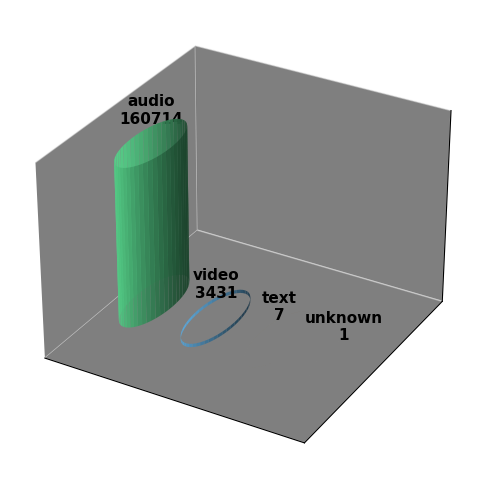

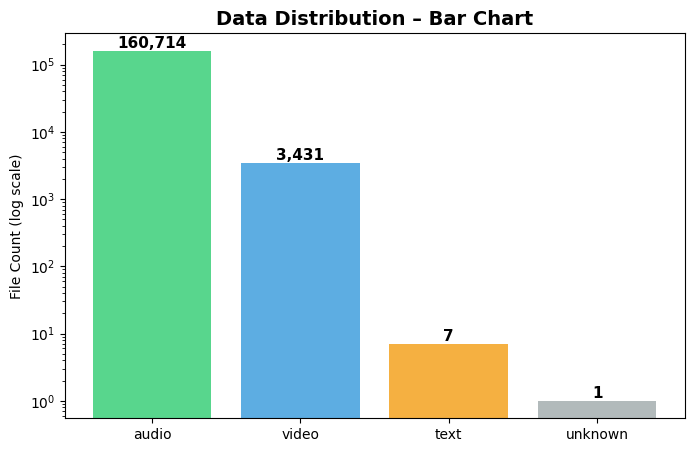

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Load manifest ---
MANIFEST = "/content/drive/MyDrive/processed/intake_manifest.csv"
df = pd.read_csv(MANIFEST)
counts = df["modality"].value_counts().to_dict()

# Ensure fixed ordering
BINS = ["audio", "video", "text", "unknown"]
counts = {k: counts.get(k, 0) for k in BINS}

# =======================
# 1. Cylinders (3D containers)
# =======================
def draw_cylinder(ax, x0, y0, r, h, color):
    theta = np.linspace(0, 2*np.pi, 50)
    z = np.linspace(0, h, 2)
    theta_grid, z_grid = np.meshgrid(theta, z)
    X = r*np.cos(theta_grid) + x0
    Y = r*np.sin(theta_grid) + y0
    ax.plot_surface(X, Y, z_grid, linewidth=0, antialiased=True,
                    shade=True, color=color, alpha=0.95)

heights = {k: (v / max(counts.values())) * 5 for k,v in counts.items()}
x_positions = np.arange(len(BINS)) * 2.0
colors = ["#58D68D","#5DADE2","#F5B041","#B2BABB"]

fig = plt.figure(figsize=(10,6), facecolor='none')
ax = fig.add_subplot(111, projection='3d', facecolor='none')

for i, key in enumerate(BINS):
    draw_cylinder(ax, x_positions[i], 0, 0.6, heights[key], colors[i])
    ax.text(x_positions[i], 0, heights[key]+0.5,
            f"{key}\n{counts[key]}",
            ha='center', va='bottom', fontsize=11, weight='bold')

ax.set_xlim(-1, x_positions[-1]+1)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(0, 6)
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.grid(False)
ax.xaxis.pane.set_facecolor((0,0,0,0))
ax.yaxis.pane.set_facecolor((0,0,0,0))
ax.zaxis.pane.set_facecolor((0,0,0,0))


# =======================
# 2. 2D Bar Chart
# =======================
plt.figure(figsize=(8,5))
bars = plt.bar(counts.keys(), counts.values(), color=colors)
plt.bar_label(bars, labels=[f"{v:,}" for v in counts.values()], fontsize=11, weight="bold")
plt.yscale("log")  # optional: log scale, helps show imbalance
plt.title("Data Distribution – Bar Chart", fontsize=14, weight="bold")
plt.ylabel("File Count (log scale)")
plt.show()


Text pipeline in agentic AI

In [24]:
# ===== Fix environment versions (Colab) =====
# 1) keep NumPy < 2
!pip install -q "numpy<2"

# 2) match torch / torchaudio / torchvision (CUDA 12.6 build that Colab uses)
!pip install -q torch==2.8.0 torchaudio==2.8.0 torchvision==0.23.0 --extra-index-url https://download.pytorch.org/whl/cu126

# 3) core libs for our pipelines
!pip install -q transformers==4.44.2 regex tldextract urlextract textstat \
                 librosa==0.10.2.post1 soundfile scikit-learn==1.5.2 pandas==2.2.2 tqdm

print("✅ Installed. Now go to: Runtime -> Restart runtime")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 35.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
torchvision 0.23.0+cu126 requires torch==2.8.0, but you have torch 2.2.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.8/821.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━

In [26]:
!pip uninstall -y transformers huggingface_hub safetensors

Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2
Found existing installation: huggingface-hub 0.34.4
Uninstalling huggingface-hub-0.34.4:
  Successfully uninstalled huggingface-hub-0.34.4
Found existing installation: safetensors 0.6.2
Uninstalling safetensors-0.6.2:
  Successfully uninstalled safetensors-0.6.2


In [28]:
!pip uninstall -y transformers huggingface-hub safetensors accelerate peft datasets diffusers

Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Found existing installation: huggingface-hub 0.23.2
Uninstalling huggingface-hub-0.23.2:
  Successfully uninstalled huggingface-hub-0.23.2
Found existing installation: safetensors 0.4.2
Uninstalling safetensors-0.4.2:
  Successfully uninstalled safetensors-0.4.2
Found existing installation: accelerate 1.10.1
Uninstalling accelerate-1.10.1:
  Successfully uninstalled accelerate-1.10.1
Found existing installation: peft 0.17.1
Uninstalling peft-0.17.1:
  Successfully uninstalled peft-0.17.1
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
Found existing installation: diffusers 0.35.1
Uninstalling diffusers-0.35.1:
  Successfully uninstalled diffusers-0.35.1


In [30]:
!pip uninstall -y gradio gcsfs
!pip install -q \
  "transformers==4.44.2" \
  "huggingface-hub==0.24.6" \
  "safetensors==0.4.5" \
  "accelerate==0.34.2" \
  "peft==0.12.0" \
  "datasets==3.0.2" \
  "diffusers==0.30.2" \
  "fsspec==2024.9.0"


Found existing installation: gradio 5.44.1
Uninstalling gradio-5.44.1:
  Successfully uninstalled gradio-5.44.1
Found existing installation: gcsfs 2025.3.0
Uninstalling gcsfs-2025.3.0:
  Successfully uninstalled gcsfs-2025.3.0


In [1]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# check torch & cuda
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Quick HF test: sentiment analysis pipeline
sentiment = pipeline("sentiment-analysis")
print("Test sentiment:", sentiment("I love using HuggingFace Transformers!"))


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Torch version: 2.8.0+cu126
CUDA available: False


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Test sentiment: [{'label': 'POSITIVE', 'score': 0.9898301959037781}]


In [3]:
import pandas as pd
import os

# Path to preprocessed email dataset
TEXT_DIR = "/content/email_phishing_dataset"

dfs = []
for fname in os.listdir(TEXT_DIR):
    if fname.endswith(".csv"):
        fpath = os.path.join(TEXT_DIR, fname)
        try:
            # ✅ FIX: removed errors= argument
            df = pd.read_csv(fpath, encoding="utf-8")
            df["source_file"] = fname   # keep origin
            dfs.append(df)
            print(f"✅ Loaded {fname} with {len(df)} rows")
        except Exception as e:
            print(f"⚠️ Skipping {fname}: {e}")

# ✅ Only concat if we got at least one dataframe
if dfs:
    df_emails = pd.concat(dfs, ignore_index=True)
    print("\n=== Dataset Summary ===")
    print("Total rows:", len(df_emails))
    print("Columns:", df_emails.columns.tolist())
    print(df_emails.head())
else:
    print("❌ No CSVs loaded. Please check file format.")


✅ Loaded Nigerian_Fraud.csv with 3332 rows
✅ Loaded Enron.csv with 29767 rows
✅ Loaded Nazario.csv with 1565 rows
✅ Loaded phishing_email.csv with 82486 rows
✅ Loaded CEAS_08.csv with 39154 rows
✅ Loaded SpamAssasin.csv with 5809 rows
✅ Loaded Ling.csv with 2859 rows

=== Dataset Summary ===
Total rows: 164972
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label', 'source_file', 'text_combined']
                                           sender              receiver  \
0  MR. JAMES NGOLA. <james_ngola2002@maktoob.com>  webmaster@aclweb.org   
1  Mr. Ben Suleman <bensul2004nng@spinfinder.com>                   R@M   
2       PRINCE OBONG ELEME <obong_715@epatra.com>  webmaster@aclweb.org   
3       PRINCE OBONG ELEME <obong_715@epatra.com>  webmaster@aclweb.org   
4              Maryam Abacha <m_abacha03@www.com>                   R@M   

                              date  \
0  Thu, 31 Oct 2002 02:38:20 +0000   
1  Thu, 31 Oct 2002 05:10:00 -0000   
2  Thu, 31 Oct 

In [4]:
# Merge subject + body (if present)
if "subject" in df_emails.columns and "body" in df_emails.columns:
    df_emails["text"] = (
        df_emails["subject"].fillna("") + " " + df_emails["body"].fillna("")
    )
elif "body" in df_emails.columns:
    df_emails["text"] = df_emails["body"].fillna("")
elif "content" in df_emails.columns:
    df_emails["text"] = df_emails["content"].fillna("")
else:
    raise ValueError("No suitable text column found in dataset")

print("Sample combined text:\n", df_emails["text"].head(3).tolist())


Sample combined text:
 ['URGENT BUSINESS ASSISTANCE AND PARTNERSHIP FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-27-587908.\nE-MAIL: (james_ngola2002@maktoob.com).\n\nURGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\n\nDEAR FRIEND,\n\nI AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY GUARD ON 16TH JAN. 2001.\n\n\nTHE INCIDENT OCCURRED IN OUR PRESENCE WHILE WE WERE HOLDING MEETING WITH HIS EXCELLENCY OVER THE FINANCIAL RETURNS FROM THE DIAMOND SALES IN THE AREAS CONTROLLED BY (D.R.C.) DEMOCRATIC REPUBLIC OF CONGO FORCES AND THEIR FOREIGN ALLIES ANGOLA AND ZIMBABWE, HAVING RECEIVED THE PREVIOUS DAY (USD$100M) ONE HUNDRED MILLION UNITED STATES DOLLARS, CASH IN THREE DIPLOMATIC BOXES ROUTED THROUGH ZIMBABWE.\n\nMY PURPOSE OF WRITING YOU THIS LETTER IS TO SOLICIT FOR YOUR ASSISTANCE AS TO BE A COVER TO THE FUND AND ALSO COLLABORATION IN MOVING THE SAID FUND INTO YOUR BANK ACCOUNT THE SUM OF (USD$25M) TWENTY FIVE M

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

MODELS = {
    "phishing": "mrm8488/bert-tiny-finetuned-sms-spam-detection",
    "sentiment": "distilbert-base-uncased-finetuned-sst-2-english",
    "toxic": "unitary/toxic-bert"
}

pipes = {}

for name, model_name in MODELS.items():
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    pipes[name] = pipeline("text-classification", model=model, tokenizer=tok, device=-1)


In [11]:
def chunk_text(text, tokenizer, max_len=512, stride=256):
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    chunks = []
    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i+max_len]
        if len(chunk) < 5:
            break
        chunks.append(tokenizer.decode(chunk, skip_special_tokens=True))
    return chunks

def classify_with_chunks(pipe, tokenizer, text, max_len=512):
    chunks = chunk_text(text, tokenizer, max_len=max_len)
    if not chunks:
        return {"label": "EMPTY", "score": 0.0}

    preds = pipe(chunks, truncation=True, max_length=max_len)

    # aggregate results: just take the label with highest score overall
    best_pred = max(preds, key=lambda p: p["score"])
    return best_pred


In [12]:
from tqdm import tqdm

results = []

for t in tqdm(df_emails["text"].tolist()[:50]):  # limit for speed
    row_res = {}
    for name, pipe in pipes.items():
        tokenizer = pipe.tokenizer
        row_res[name] = classify_with_chunks(pipe, tokenizer, t)
    results.append(row_res)

# Example: show first few results
for i, r in enumerate(results[:3]):
    print(f"\nEmail {i+1}:")
    for model_name, pred in r.items():
        print(f"  {model_name}: {pred}")


  0%|          | 0/50 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 50/50 [06:33<00:00,  7.86s/it]


Email 1:
  phishing: {'label': 'LABEL_0', 'score': 0.9099285006523132}
  sentiment: {'label': 'POSITIVE', 'score': 0.9885538816452026}
  toxic: {'label': 'toxic', 'score': 0.0007200418622232974}

Email 2:
  phishing: {'label': 'LABEL_0', 'score': 0.88372802734375}
  sentiment: {'label': 'NEGATIVE', 'score': 0.9935351610183716}
  toxic: {'label': 'toxic', 'score': 0.0007260888232849538}

Email 3:
  phishing: {'label': 'LABEL_0', 'score': 0.872854471206665}
  sentiment: {'label': 'POSITIVE', 'score': 0.9582351446151733}
  toxic: {'label': 'toxic', 'score': 0.0007256534299813211}


In [13]:
import pandas as pd

df_results = pd.DataFrame([
    {
        "email": df_emails["text"].iloc[i],
        "phishing_label": r["phishing"]["label"],
        "phishing_score": r["phishing"]["score"],
        "sentiment_label": r["sentiment"]["label"],
        "sentiment_score": r["sentiment"]["score"],
        "toxic_label": r["toxic"]["label"],
        "toxic_score": r["toxic"]["score"],
    }
    for i, r in enumerate(results)
])

df_results.head()


,email,phishing_label,phishing_score,sentiment_label,sentiment_score,toxic_label,toxic_score
0,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP FRO...,LABEL_0,0.909929,POSITIVE,0.988554,toxic,0.000720
1,URGENT ASSISTANCE /RELATIONSHIP (P) Dear Frien...,LABEL_0,0.883728,NEGATIVE,0.993535,toxic,0.000726
2,GOOD DAY TO YOU FROM HIS ROYAL MAJESTY (HRM) C...,LABEL_0,0.872854,POSITIVE,0.958235,toxic,0.000726
3,GOOD DAY TO YOU FROM HIS ROYAL MAJESTY (HRM) C...,LABEL_0,0.874205,POSITIVE,0.962273,toxic,0.000746
4,"I Need Your Assistance. Dear sir, \n \nIt is w...",LABEL_0,0.910677,POSITIVE,0.998879,toxic,0.000874


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [6]:
import os

print("Top-level:", os.listdir("/content/drive"))
print("MyDrive contents:", os.listdir("/content/drive/MyDrive")[:10])


Top-level: ['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']
MyDrive contents: ['Tech M Project Progress', 'Tamanna_Resumes', 'Imagica Pics', 'Japan_Tech_M', 'MUFG SIH', 'Dataset files_MUFG_SIH.gdoc', 'Colab Notebooks', 'processed']


In [7]:
print("MUFG SIH contents:", os.listdir("/content/drive/MyDrive/MUFG SIH"))


MUFG SIH contents: ['email_phishing_dataset.zip', 'Dataset files_MUFG_SIH.gdoc', 'AgenticAI_approach.svg', 'Deepfake_video.zip', 'MUFG', 'SIH2025_Presentation.pptx.pdf', 'Deepfake_audio.zip', 'phishnet', 'processed_audio_mfcc.csv']


In [8]:
import os, zipfile

DRIVE_DIR = "/content/drive/MyDrive/MUFG SIH"
ZIP_PATH  = os.path.join(DRIVE_DIR, "email_phishing_dataset.zip")
OUT_DIR   = "/content/email_phishing_dataset"

assert os.path.exists(ZIP_PATH), f"Zip not found at {ZIP_PATH}"

# Fresh extract (idempotent)
if os.path.exists(OUT_DIR) and not os.listdir(OUT_DIR):
    # exists but empty; keep it
    pass
elif not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR, exist_ok=True)

# Only extract if folder seems empty
if len(os.listdir(OUT_DIR)) == 0:
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(OUT_DIR)
    print("✅ Extracted to:", OUT_DIR)
else:
    print("ℹ️ Skipping extract (already present):", OUT_DIR)

print("Top-level inside OUT_DIR:", os.listdir(OUT_DIR)[:10])


✅ Extracted to: /content/email_phishing_dataset
Top-level inside OUT_DIR: ['Enron.csv', 'phishing_email.csv', 'Nazario.csv', 'CEAS_08.csv', 'SpamAssasin.csv', 'Nigerian_Fraud.csv', 'Ling.csv']


In [9]:
import os, pandas as pd

base_dir = "/content/email_phishing_dataset"  # extracted in Step A

# collect all CSVs
csv_files = []
for root, _, files in os.walk(base_dir):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))

if not csv_files:
    raise FileNotFoundError(f"❌ No CSV files found under {base_dir}")

print(f"✅ Found {len(csv_files)} CSV files")
for f in csv_files:
    print(" -", f)

dfs = []
for f in csv_files:
    try:
        df_tmp = pd.read_csv(f, encoding="utf-8", on_bad_lines="skip")
        df_tmp["source_file"] = os.path.basename(f)

        # build a 'text' column if missing
        if "text" not in df_tmp.columns:
            possible = [c for c in df_tmp.columns if c.lower() in ["subject","body","message","content","email_text","text_"]]
            if possible:
                df_tmp["text"] = df_tmp[possible].astype(str).agg(" ".join, axis=1)
            else:
                # fallback: entire row flattened
                df_tmp["text"] = df_tmp.astype(str).agg(" ".join, axis=1)

        dfs.append(df_tmp[["source_file","text"]])
    except Exception as e:
        print(f"⚠️ Skipping {f}: {e}")

if not dfs:
    raise ValueError("❌ No usable CSVs produced a 'text' column.")

df_emails = pd.concat(dfs, ignore_index=True)
print("📊 Combined rows:", len(df_emails))
df_emails.head()


✅ Found 7 CSV files
 - /content/email_phishing_dataset/Enron.csv
 - /content/email_phishing_dataset/phishing_email.csv
 - /content/email_phishing_dataset/Nazario.csv
 - /content/email_phishing_dataset/CEAS_08.csv
 - /content/email_phishing_dataset/SpamAssasin.csv
 - /content/email_phishing_dataset/Nigerian_Fraud.csv
 - /content/email_phishing_dataset/Ling.csv
📊 Combined rows: 164972


,source_file,text
0,Enron.csv,"hpl nom for may 25 , 2001 ( see attached file ..."
1,Enron.csv,re : nom / actual vols for 24 th - - - - - - -...
2,Enron.csv,"enron actuals for march 30 - april 1 , 201 est..."
3,Enron.csv,"hpl nom for may 30 , 2001 ( see attached file ..."
4,Enron.csv,"hpl nom for june 1 , 2001 ( see attached file ..."


In [10]:
# ============================================================
# Agentic AI Text Pipeline (FAST VERSION)
# ============================================================

!pip -q install tldextract urlextract regex

import re, regex as re2
import tldextract
from urlextract import URLExtract
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# ============================================================
# 1. Load a single phishing model (fast + lightweight)
# ============================================================

MODEL_NAME = "mrm8488/bert-tiny-finetuned-sms-spam-detection"  # tiny model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
phish_clf = pipeline("text-classification", model=model, tokenizer=tokenizer, device=-1)

print("✅ Model loaded")

# ============================================================
# 2. Heuristic detectors
# ============================================================

EXTRACTOR = URLExtract()
SHORTENERS = ("bit.ly","tinyurl.com","t.co","goo.gl","ow.ly","is.gd","buff.ly","rb.gy","rebrand.ly")
SUSPICIOUS_TLDS = ("zip","mov","xyz","top","club","quest","gq","tk","cf","ml")
BRANDS = ("paypal","apple","microsoft","amazon","bank","google","mufg","icici","hdfc","sbi")
URGENCY = ("urgent","immediately","verify","suspended","locked","reset","otp",
           "wire transfer","invoice","payment due","click here")

INVISIBLE = r"[\u200B-\u200F\u2060\uFEFF]"
MIXED_SCRIPTS = r"[\p{Greek}\p{Cyrillic}\p{Arabic}\p{Devanagari}]"

def safe_domain(url: str) -> str:
    try:
        ext = tldextract.extract(url)
        dom = ".".join([p for p in [ext.domain, ext.suffix] if p])
        return dom.lower()
    except Exception:
        return ""

def context_risk(text: str) -> dict:
    lower = text.lower()
    urls  = EXTRACTOR.find_urls(text)
    domains = [safe_domain(u) for u in urls if u]

    urgent_hits = sum(kw in lower for kw in URGENCY)
    short_hits  = sum(any(s in (d or "") for s in SHORTENERS) for d in domains)
    tld_hits    = sum(d.split(".")[-1] in SUSPICIOUS_TLDS for d in domains if "." in d)
    brand_sus   = 0
    for d in domains:
        has_brand = any(b in d for b in BRANDS)
        if has_brand and not any(d.endswith(core) for core in [f"{b}.com" for b in BRANDS]):
            brand_sus += 1

    score = 0.0
    score += min(0.35, urgent_hits * 0.08)
    score += min(0.30, short_hits * 0.15)
    score += min(0.25, tld_hits * 0.12)
    score += min(0.30, brand_sus * 0.15)
    score += min(0.30, len(urls) * 0.03)
    score = max(0.0, min(1.0, score))

    return {
        "score": round(score, 3),
        "url_count": len(urls),
        "shorteners": short_hits,
        "suspicious_tlds": tld_hits,
        "brand_spoof_signals": brand_sus,
        "urgent_hits": urgent_hits,
        "sample_domains": domains[:6],
    }

def watermarkish(text: str) -> dict:
    inv   = bool(re2.search(INVISIBLE, text))
    nonas = bool(re.search(r"[^\x00-\x7F]", text))
    mixed = bool(re2.search(MIXED_SCRIPTS, text))
    many_excls = bool(re.search(r"!{2,}", text))
    caps_ratio = (sum(1 for c in text if c.isupper()) / max(1, len(text)))

    wm_score = 0.0
    wm_score += 0.4 if inv else 0.0
    wm_score += 0.2 if mixed else 0.0
    wm_score += 0.1 if nonas else 0.0
    wm_score += 0.1 if many_excls else 0.0
    wm_score += 0.2 if caps_ratio > 0.15 else 0.0

    return {
        "invisible_unicode": inv,
        "mixed_scripts": mixed,
        "non_ascii": nonas,
        "many_exclamations": many_excls,
        "uppercase_ratio": round(caps_ratio,4),
        "watermark_like_score": round(min(1.0, wm_score),3),
    }

# ============================================================
# 3. Run pipeline on your df_emails
# ============================================================

# ⚠️ Assumes df_emails is already defined with a 'text' column
results = []
for txt in tqdm(df_emails["text"].astype(str).tolist()):
    r_model = phish_clf(txt[:512])[0]  # truncate to 512 tokens
    r_context = context_risk(txt)
    r_wm = watermarkish(txt)

    label = r_model["label"].lower()
    conf  = r_model["score"]
    risk  = r_context["score"]
    wm    = r_wm["watermark_like_score"]

    is_phish = (label in ("spam","phishing","label_1"))
    p_adj = (conf if is_phish else 1 - conf) + 0.35*risk + 0.15*wm
    p_adj = max(0.0, min(1.0, p_adj))

    results.append({
        "raw_label": label,
        "raw_conf": round(conf,3),
        "context_risk": risk,
        "wm_score": wm,
        "agentic_label": "PHISHING" if p_adj>=0.5 else "SAFE",
        "agentic_prob": round(p_adj,3),
    })

df_out = pd.concat([df_emails.reset_index(drop=True), pd.DataFrame(results)], axis=1)

save_path = "/content/drive/MyDrive/processed/phishing_agentic_fast.csv"
df_out.to_csv(save_path, index=False)
print(f"✅ Saved results to {save_path}")
print(df_out.head(5))


Device set to use cpu


✅ Model loaded


100%|██████████| 164972/164972 [46:33<00:00, 59.06it/s]


✅ Saved results to /content/drive/MyDrive/processed/phishing_agentic_fast.csv
  source_file                                               text raw_label  \
0   Enron.csv  hpl nom for may 25 , 2001 ( see attached file ...   label_1   
1   Enron.csv  re : nom / actual vols for 24 th - - - - - - -...   label_1   
2   Enron.csv  enron actuals for march 30 - april 1 , 201 est...   label_0   
3   Enron.csv  hpl nom for may 30 , 2001 ( see attached file ...   label_1   
4   Enron.csv  hpl nom for june 1 , 2001 ( see attached file ...   label_1   

   raw_conf  context_risk  wm_score agentic_label  agentic_prob  
0     0.804           0.0       0.0      PHISHING         0.804  
1     0.629           0.0       0.0      PHISHING         0.629  
2     0.848           0.0       0.0          SAFE         0.152  
3     0.798           0.0       0.0      PHISHING         0.798  
4     0.882           0.0       0.0      PHISHING         0.882  


In [11]:
import pandas as pd

path = "/content/drive/MyDrive/processed/phishing_agentic_fast.csv"
df = pd.read_csv(path)

# Overall distribution
print("Counts:")
print(df["agentic_label"].value_counts(), "\n")

# Bucket by fused probability
def bucket(p):
    if p >= 0.70: return "HIGH_RISK"
    if p >= 0.50: return "REVIEW"
    return "LOW_RISK"

df["bucket"] = df["agentic_prob"].apply(bucket)
print("Buckets:")
print(df["bucket"].value_counts(), "\n")

# Per-source breakdown
print("Per-source (first 10):")
print(df.groupby(["source_file","bucket"]).size().unstack(fill_value=0).head(10))


Counts:
agentic_label
PHISHING    127733
SAFE         37239
Name: count, dtype: int64 

Buckets:
bucket
HIGH_RISK    110920
LOW_RISK      37208
REVIEW        16844
Name: count, dtype: int64 

Per-source (first 10):
bucket              HIGH_RISK  LOW_RISK  REVIEW
source_file                                    
CEAS_08.csv             19666     13497    5991
Enron.csv               10453     15224    4090
Ling.csv                  792      1399     668
Nazario.csv               709       557     299
Nigerian_Fraud.csv        593      2559     180
SpamAssasin.csv          2708      2437     664
phishing_email.csv      75999      1535    4952


In [12]:
rev = df[df["bucket"]=="REVIEW"].sample(n=min(1000, len(df[df["bucket"]=="REVIEW"])), random_state=7)
hi  = df[df["bucket"]=="HIGH_RISK"].sample(n=min(1000, len(df[df["bucket"]=="HIGH_RISK"])), random_state=7)

rev_path = "/content/drive/MyDrive/processed/review_samples.csv"
hi_path  = "/content/drive/MyDrive/processed/highrisk_samples.csv"
rev.to_csv(rev_path, index=False)
hi.to_csv(hi_path, index=False)
print("Saved:")
print(" -", rev_path)
print(" -", hi_path)


Saved:
 - /content/drive/MyDrive/processed/review_samples.csv
 - /content/drive/MyDrive/processed/highrisk_samples.csv


In [13]:
def label_from_prob(p, lo=0.50, hi=0.70):
    if p >= hi: return "HIGH_RISK"
    if p >= lo: return "REVIEW"
    return "LOW_RISK"

cal = []
for src, g in df.groupby("source_file"):
    # pick thresholds using percentiles
    p70 = g["agentic_prob"].quantile(0.70)
    p85 = g["agentic_prob"].quantile(0.85)
    cal.append({"source_file": src, "t_lo": round(p70,3), "t_hi": round(p85,3)})

cal_df = pd.DataFrame(cal).sort_values("source_file")
print(cal_df)

# apply custom thresholds per source
df2 = df.merge(cal_df, on="source_file", how="left")
df2["bucket_src"] = df2.apply(lambda r: label_from_prob(r["agentic_prob"], lo=r["t_lo"], hi=r["t_hi"]), axis=1)

out_path = "/content/drive/MyDrive/processed/phishing_agentic_calibrated.csv"
df2.to_csv(out_path, index=False)
print("✅ Saved:", out_path)


          source_file   t_lo   t_hi
0         CEAS_08.csv  0.842  0.924
1           Enron.csv  0.748  0.844
2            Ling.csv  0.682  0.798
3         Nazario.csv  0.805  0.899
4  Nigerian_Fraud.csv  0.346  0.783
5     SpamAssasin.csv  0.850  0.914
6  phishing_email.csv  0.892  0.902
✅ Saved: /content/drive/MyDrive/processed/phishing_agentic_calibrated.csv


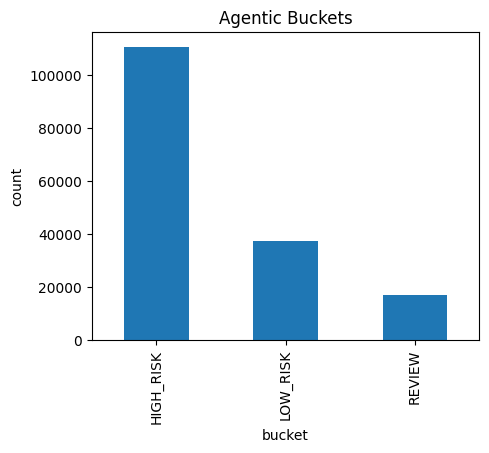

In [14]:
import matplotlib.pyplot as plt

vc = df["bucket"].value_counts()
plt.figure(figsize=(5,4))
vc.plot(kind="bar")
plt.title("Agentic Buckets")
plt.xlabel("bucket")
plt.ylabel("count")
plt.show()


In [15]:
ALLOW = ("@enron.com", "@mufg.jp", "@mufg.com")
def looks_internal(text):
    # crude heuristic: find “From:” like strings (works if present), else search any email
    import re
    m = re.search(r"[\w\.-]+@[\w\.-]+\.\w+", text)
    return any(a in m.group(0).lower() for a in ALLOW) if m else False

df["internal_sender_guess"] = df["text"].apply(looks_internal)
# Demote internal + low context risk
mask = (df["internal_sender_guess"]) & (df["context_risk"] < 0.1) & (df["agentic_prob"] < 0.8)
df.loc[mask & (df["bucket"]=="HIGH_RISK"), "bucket"] = "REVIEW"


In [16]:
import os, glob

print(os.path.exists("/content/drive/MyDrive/processed/phishing_agentic_fast.csv"),
      "/content/drive/MyDrive/processed/phishing_agentic_fast.csv")

# if False, search broadly
matches = glob.glob("/content/drive/**/phishing_agentic_fast.csv", recursive=True)
print("Matches found:", matches[:5])


True /content/drive/MyDrive/processed/phishing_agentic_fast.csv
Matches found: ['/content/drive/MyDrive/processed/phishing_agentic_fast.csv']


In [18]:
import re
from urllib.parse import urlparse

# Loose URL regex (same as before)
URL_RE = re.compile(r'https?://[^\s)>\]"}]+', re.IGNORECASE)

def _sanitize_url(u: str) -> str:
    """
    Trim obvious trailing punctuation / unmatched brackets that often sneak into CSV text.
    """
    u = u.strip().strip('.,;:!?)"]}')
    # remove a dangling '[' or '(' at the end, or a leading one
    if u.endswith('[') or u.endswith('('):
        u = u[:-1]
    if u.startswith('[') or u.startswith('('):
        u = u[1:]
    return u

def domains_from_text(text):
    urls = URL_RE.findall(str(text) or "")
    doms = []
    n = 0
    for raw in urls:
        u = _sanitize_url(raw)
        try:
            p = urlparse(u)
            net = (p.netloc or "").lower()
            # Skip clearly broken IPv6-like netlocs (unbalanced brackets, etc.)
            if net.count('[') != net.count(']'):
                continue
            if net.startswith("www."):
                net = net[4:]
            if net:
                doms.append(net)
            n += 1
        except Exception:
            # swallow ValueError: Invalid IPv6 URL and any other parse errors
            continue
    return doms, n

# Recompute only if needed:
if "url_count" not in df.columns:
    url_counts, all_domains = [], []
    for t in df["text"].astype(str):
        doms, n = domains_from_text(t)
        url_counts.append(n)
        all_domains.extend(doms)
    df["url_count"] = url_counts
else:
    all_domains = []
    for t in df["text"].astype(str):
        doms, _ = domains_from_text(t)
        all_domains.extend(doms)

# Rebuild domain frequency and continue with the plots below as-is
domain_freq = pd.Series(all_domains).value_counts().head(20).reset_index()
domain_freq.columns = ["domain", "count"]


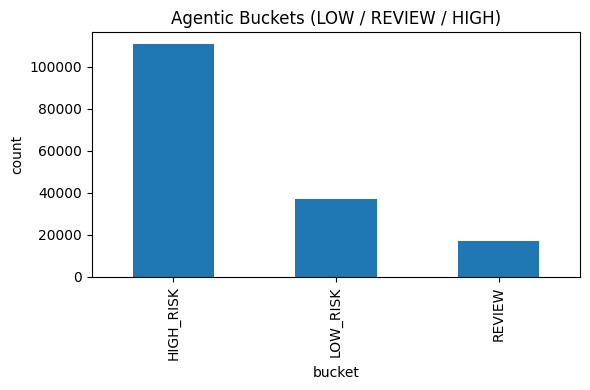

Counts by bucket:
 bucket
HIGH_RISK    110920
LOW_RISK      37208
REVIEW        16844
Name: count, dtype: int64


In [20]:
# Viz #1 — Bucket distribution (bar chart)
import os, re
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse

CSV_PATH = "/content/drive/MyDrive/processed/phishing_agentic_fast.csv"  # <-- your file
assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
required = {"text","agentic_prob","agentic_label","source_file","context_risk","wm_score"}
missing = required - set(df.columns)
assert not missing, f"Missing columns: {missing}"

def bucket(p, lo=0.50, hi=0.70):
    if p >= hi: return "HIGH_RISK"
    if p >= lo: return "REVIEW"
    return "LOW_RISK"

df["bucket"] = df["agentic_prob"].apply(bucket)
counts = df["bucket"].value_counts().sort_index()

plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Agentic Buckets (LOW / REVIEW / HIGH)")
plt.xlabel("bucket")
plt.ylabel("count")
plt.tight_layout()
plt.show()

print("Counts by bucket:\n", counts)


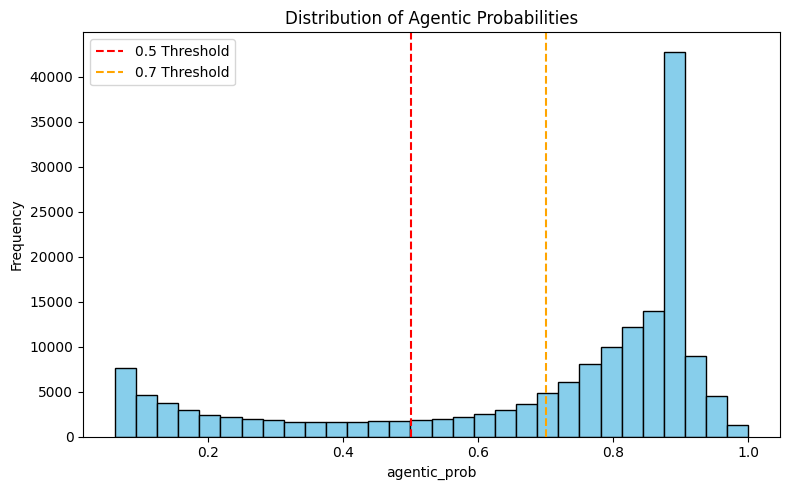

In [21]:
# Viz #2 — Probability histogram
plt.figure(figsize=(8,5))
plt.hist(df["agentic_prob"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Agentic Probabilities")
plt.xlabel("agentic_prob")
plt.ylabel("Frequency")
plt.axvline(0.5, color="red", linestyle="--", label="0.5 Threshold")
plt.axvline(0.7, color="orange", linestyle="--", label="0.7 Threshold")
plt.legend()
plt.tight_layout()
plt.show()


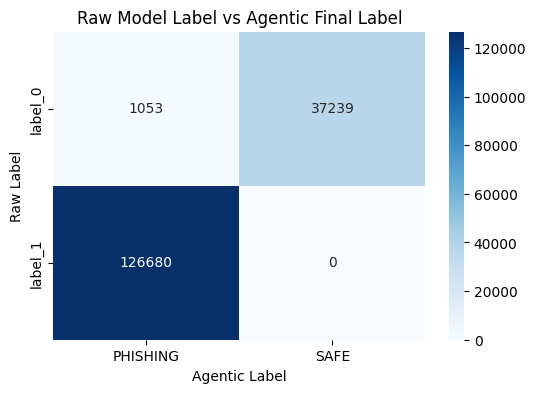

In [22]:
# Viz #3 — Confusion-style heatmap (raw vs agentic)
import seaborn as sns

cm = pd.crosstab(df["raw_label"], df["agentic_label"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Raw Model Label vs Agentic Final Label")
plt.xlabel("Agentic Label")
plt.ylabel("Raw Label")
plt.show()


/tmp/ipython-input-2256747718.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_domains, x="count", y="domain", palette="crest")


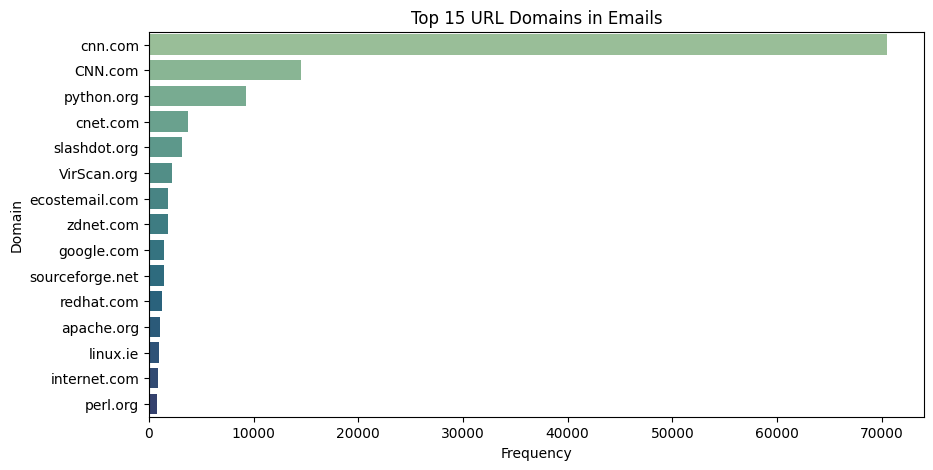

In [23]:
# Viz #4 — Top URL domains
from collections import Counter

def domains_from_text(text):
    urls = EXTRACTOR.find_urls(text)
    doms = []
    for u in urls:
        try:
            ext = tldextract.extract(u)
            doms.append(".".join([ext.domain, ext.suffix]))
        except:
            continue
    return doms

all_domains = []
for t in df["text"].astype(str).tolist():
    all_domains.extend(domains_from_text(t))

dom_counts = Counter(all_domains)
top_domains = pd.DataFrame(dom_counts.most_common(15), columns=["domain","count"])

plt.figure(figsize=(10,5))
sns.barplot(data=top_domains, x="count", y="domain", palette="crest")
plt.title("Top 15 URL Domains in Emails")
plt.xlabel("Frequency")
plt.ylabel("Domain")
plt.show()


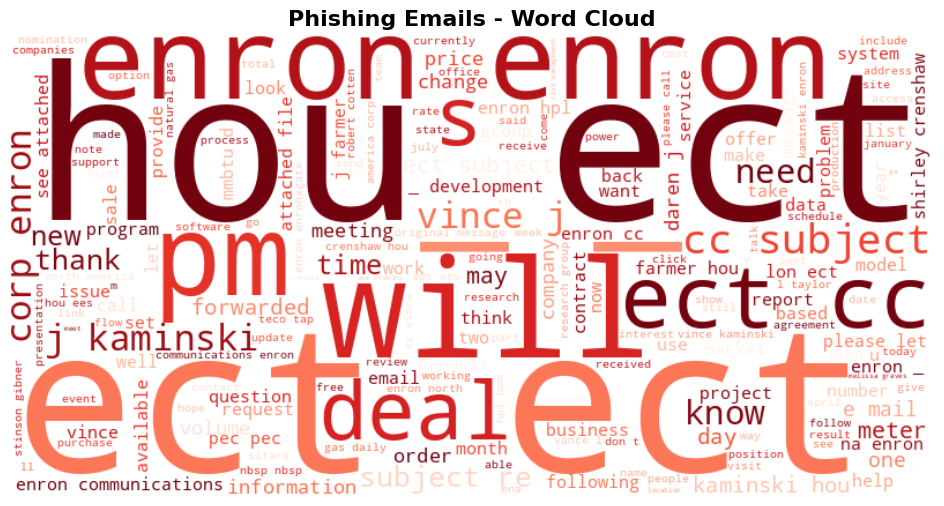

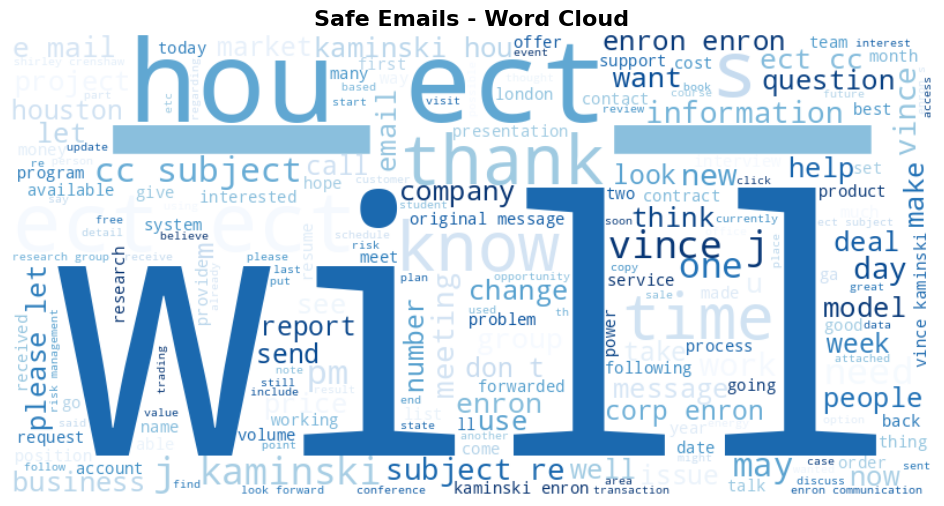

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Split phishing vs safe
phish_texts = " ".join(df[df["agentic_label"]=="PHISHING"]["text"].astype(str).tolist()[:5000])
safe_texts  = " ".join(df[df["agentic_label"]=="SAFE"]["text"].astype(str).tolist()[:5000])

# WordCloud for phishing emails
wc_phish = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(phish_texts)
plt.figure(figsize=(12,6))
plt.imshow(wc_phish, interpolation="bilinear")
plt.axis("off")
plt.title("Phishing Emails - Word Cloud", fontsize=16, weight="bold")
plt.show()

# WordCloud for safe emails
wc_safe = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(safe_texts)
plt.figure(figsize=(12,6))
plt.imshow(wc_safe, interpolation="bilinear")
plt.axis("off")
plt.title("Safe Emails - Word Cloud", fontsize=16, weight="bold")
plt.show()


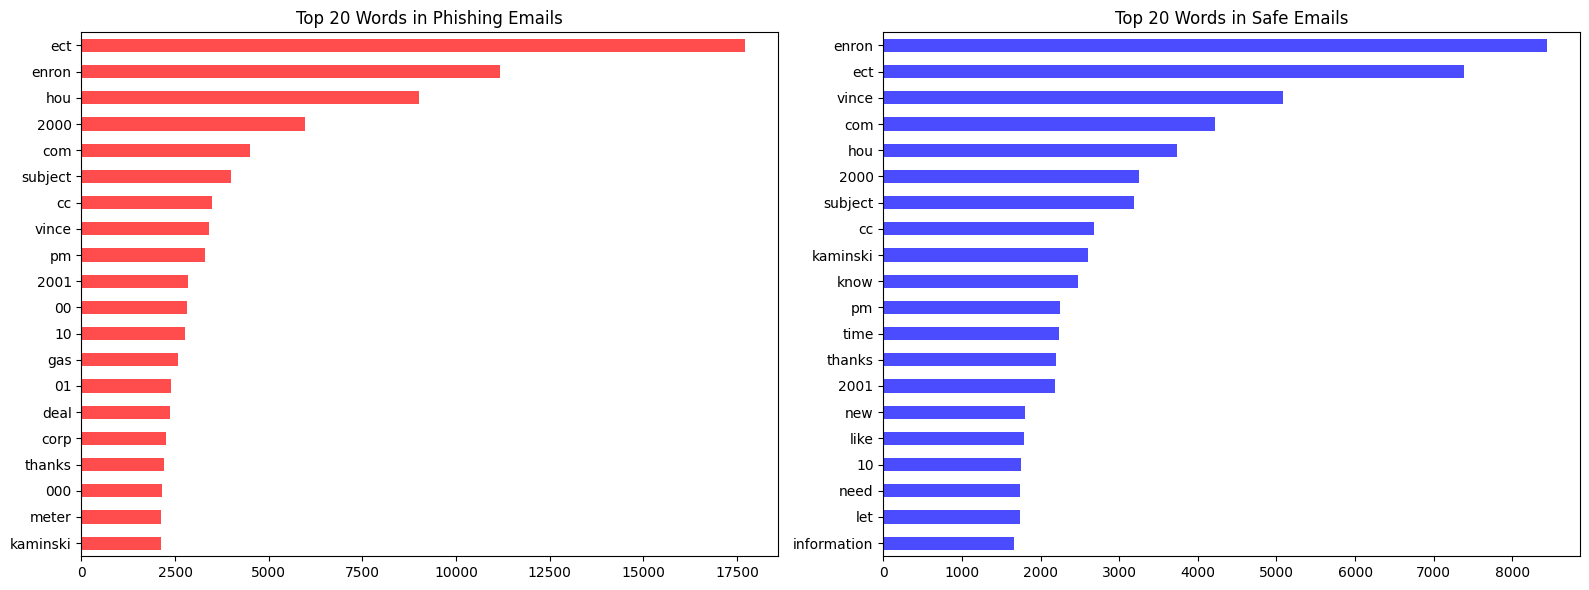

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

# Take a subset to keep it fast
phish_subset = df[df["agentic_label"]=="PHISHING"]["text"].astype(str).tolist()[:5000]
safe_subset  = df[df["agentic_label"]=="SAFE"]["text"].astype(str).tolist()[:5000]

# Vectorize
vectorizer = CountVectorizer(stop_words="english", max_features=2000)
phish_counts = vectorizer.fit_transform(phish_subset)
safe_counts  = vectorizer.transform(safe_subset)

# Sum word frequencies
phish_freq = pd.DataFrame(phish_counts.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
safe_freq  = pd.DataFrame(safe_counts.toarray(),  columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Top words for phishing
top_phish = phish_freq.head(20)
# Top words for safe
top_safe = safe_freq.head(20)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16,6))

top_phish.plot(kind="barh", ax=axes[0], color="red", alpha=0.7)
axes[0].set_title("Top 20 Words in Phishing Emails")
axes[0].invert_yaxis()

top_safe.plot(kind="barh", ax=axes[1], color="blue", alpha=0.7)
axes[1].set_title("Top 20 Words in Safe Emails")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


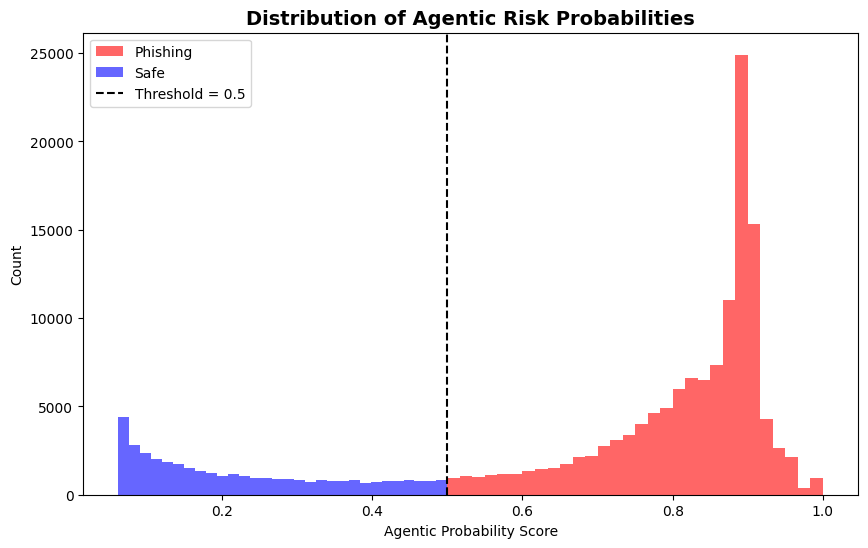

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot phishing
df[df["agentic_label"]=="PHISHING"]["agentic_prob"].plot(
    kind="hist", bins=30, alpha=0.6, color="red", label="Phishing")

# Plot safe
df[df["agentic_label"]=="SAFE"]["agentic_prob"].plot(
    kind="hist", bins=30, alpha=0.6, color="blue", label="Safe")

plt.axvline(0.5, color="black", linestyle="--", label="Threshold = 0.5")
plt.title("Distribution of Agentic Risk Probabilities", fontsize=14, weight="bold")
plt.xlabel("Agentic Probability Score")
plt.ylabel("Count")
plt.legend()
plt.show()


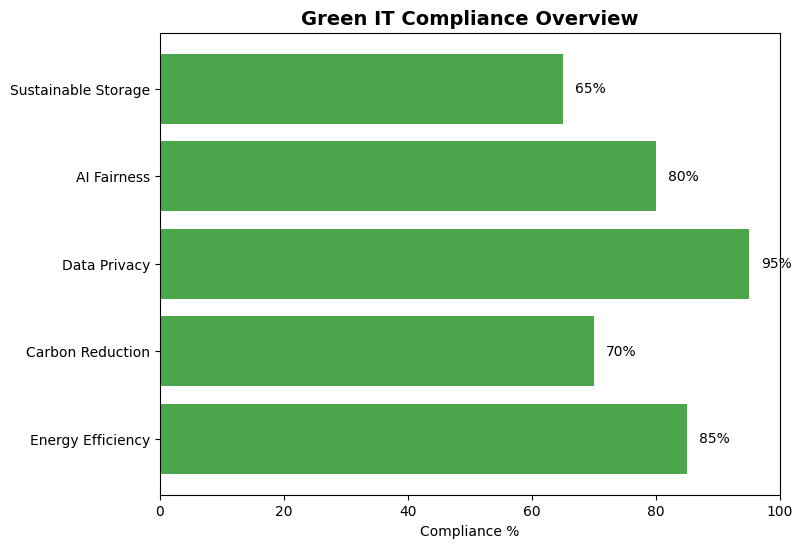

In [27]:
import matplotlib.pyplot as plt

# Example compliance metrics (you can replace with real values later)
compliance = {
    "Energy Efficiency": 85,
    "Carbon Reduction": 70,
    "Data Privacy": 95,
    "AI Fairness": 80,
    "Sustainable Storage": 65
}

plt.figure(figsize=(8,6))
bars = plt.barh(list(compliance.keys()), list(compliance.values()), color="green", alpha=0.7)
plt.xlabel("Compliance %")
plt.title("Green IT Compliance Overview", fontsize=14, weight="bold")

# Annotate values
for bar in bars:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width()}%", va="center")

plt.xlim(0, 100)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


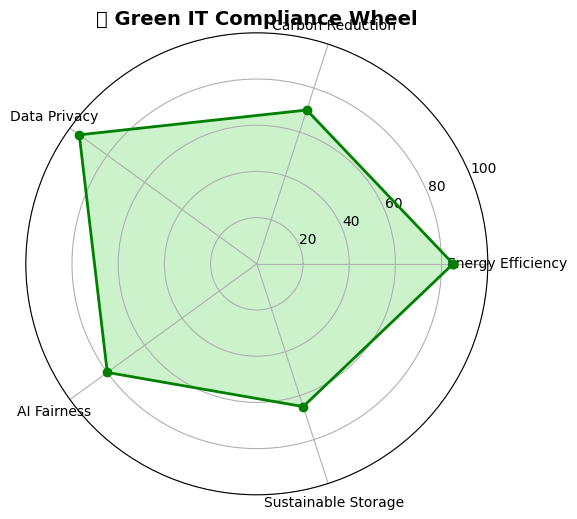

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Example compliance metrics
categories = ["Energy Efficiency", "Carbon Reduction", "Data Privacy", "AI Fairness", "Sustainable Storage"]
values = [85, 70, 95, 80, 65]

# Repeat first value to close the circle
values += values[:1]
angles = np.linspace(0, 2 * np.pi, len(values))

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
ax.plot(angles, values, 'o-', linewidth=2, color="green")
ax.fill(angles, values, alpha=0.25, color="limegreen")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticks([20,40,60,80,100])
ax.set_yticklabels(["20","40","60","80","100"])
ax.set_title("🌱 Green IT Compliance Wheel", size=14, weight="bold")

plt.show()


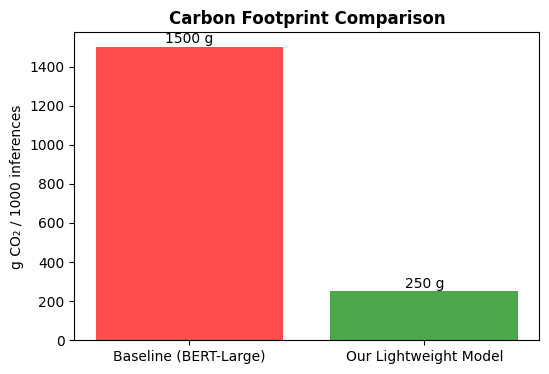

In [29]:
plt.figure(figsize=(6,4))
methods = ["Baseline (BERT-Large)", "Our Lightweight Model"]
carbon = [1500, 250]

bars = plt.bar(methods, carbon, color=["red","green"], alpha=0.7)
plt.ylabel("g CO₂ / 1000 inferences")
plt.title("Carbon Footprint Comparison", weight="bold")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+20,
             f"{bar.get_height()} g", ha="center")

plt.show()
